In [1]:
import sys

sys.path.append("../")

In [1]:
from io import StringIO

import jax
import pandas as pd
import requests
from gaussians import *
from jax import numpy as jnp
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from tueplots import bundles
from tueplots.constants.color import rgb

cmap_rw = LinearSegmentedColormap.from_list(
    "rw", [(1, 1, 1), rgb.tue_red], N=1024)
cmap_dw = LinearSegmentedColormap.from_list(
    "dw", [(1, 1, 1), rgb.tue_dark], N=1024)
cmap_bw = LinearSegmentedColormap.from_list(
    "bw", [(1, 1, 1), rgb.tue_blue], N=1024)
cmap_gw = LinearSegmentedColormap.from_list(
    "gw", [(1, 1, 1), rgb.tue_green], N=1024)
cmap_bwr = LinearSegmentedColormap.from_list(
    "bwr", [rgb.tue_blue, (1, 1, 1), rgb.tue_red], N=1024
)


plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})
jax.config.update("jax_enable_x64", True)

# Gaussian Process regression example
This example is based on the one in the book by [Rasmussen & Williams](https://gaussianprocess.org/gpml/) (Chapter 5.4)

We load weekly CO$_2$ data directly from NOAA.

In [2]:
# url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_weekly_mlo.csv"
url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv"
s = requests.get(url).text

# df = pd.read_csv(StringIO(s), sep=",", header=51, na_values="-999.99").dropna()
df = pd.read_csv(StringIO(s), sep=",", header=56, na_values="-999.99").dropna()
X = jnp.asarray(df["decimal date"])[:, None]
Y = jnp.asarray(df["average"])
N = len(X)
sigma = 0.1
print(f"Using {N} observations ranging from {X[0]} to {X[-1]}")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Using 782 observations ranging from [1958.2027] to [2023.2917]


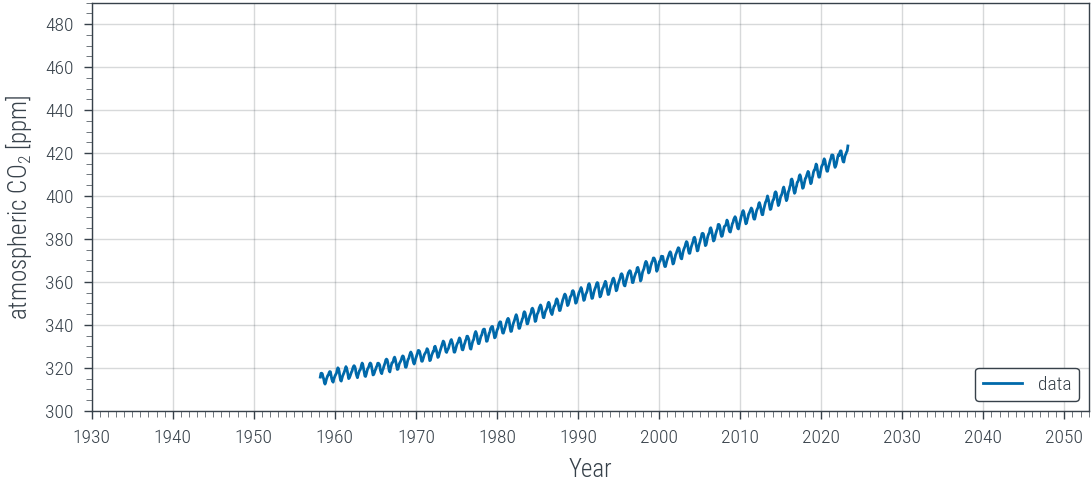

In [4]:
x = jnp.linspace(1930, 2053, 2000)[:, None]


def plot_data():
    fig, ax = plt.subplots()
    ax.plot(X, Y, label="data", color=rgb.tue_blue)

    ax.set_xlabel("Year")
    ax.set_ylabel("atmospheric CO$_2$ [ppm]")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.set_xlim([1930, 2053])
    ax.set_ylim([300, 490])
    ax.grid(which="major", axis="both")
    ax.legend(loc="lower right", framealpha=1, facecolor="w")
    return fig, ax


fig, ax = plot_data()
# fig.savefig("co2_data.pdf")

## Some first naïve approaches:

We could do *parametric regression* with linear or polynomial features, i.e. modelling the data as observations of the function $f(x)= w_1 x + w_0 = \phi(x) w$. This is equivalent to modelling the function with a GP using the *linear kernel*

$$ k(a,b) = \phi(a)^T \phi(b) = ab + 1 $$

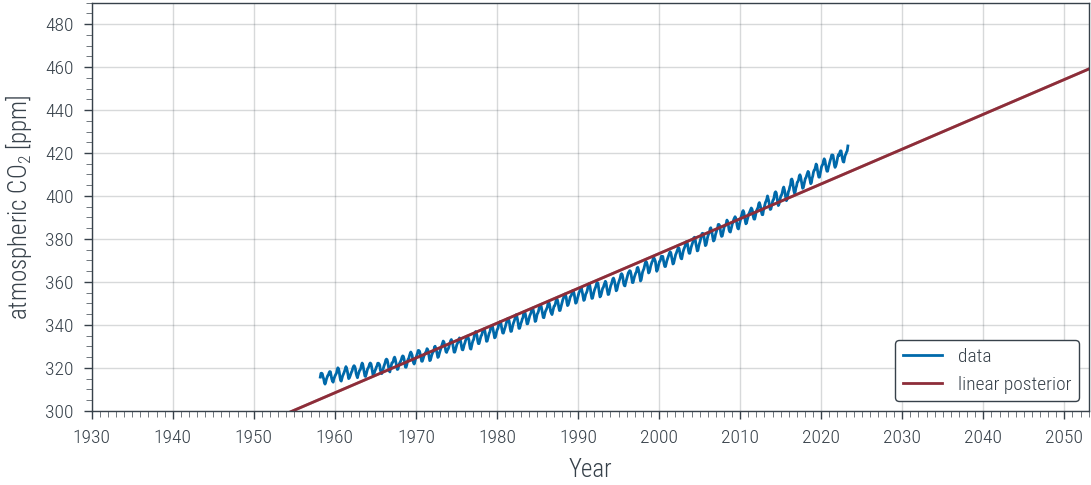

In [5]:
# we could just do linear regression, of course:
def polynomial_features(x, num_features=2):
    # output shape: (n_samples, order)
    return (
        x ** jnp.arange(num_features)
        / jnp.exp(jax.scipy.special.gammaln(jnp.arange(num_features) + 1))
        / jnp.sqrt(num_features)
    )


phi = functools.partial(polynomial_features, num_features=2)
phi_X = phi(X)
F = phi_X.shape[1]

prior = Gaussian(mu=jnp.zeros(F), Sigma=100**2 * jnp.eye(F))
posterior = prior.condition(phi_X, Y, sigma**2 * jnp.eye(len(X)))

fig, ax = plot_data()

# plot the posterior
posterior_x = phi(x) @ posterior
ax.plot(x[:, 0], posterior_x.mu, color=rgb.tue_red, label="linear posterior")
ax.fill_between(
    x[:, 0],
    posterior_x.mu - 2 * posterior_x.std,
    posterior_x.mu + 2 * posterior_x.std,
    color=rgb.tue_red,
    alpha=0.2,
)

# plot the posterior samples
num_samples = 3
key = jax.random.PRNGKey(0)
ax.plot(
    x[:, 0],
    phi(x) @ posterior.sample(key, num_samples=num_samples).T,
    color=rgb.tue_red,
    alpha=0.2,
)

ax.legend(loc="lower right", framealpha=1, facecolor="w");

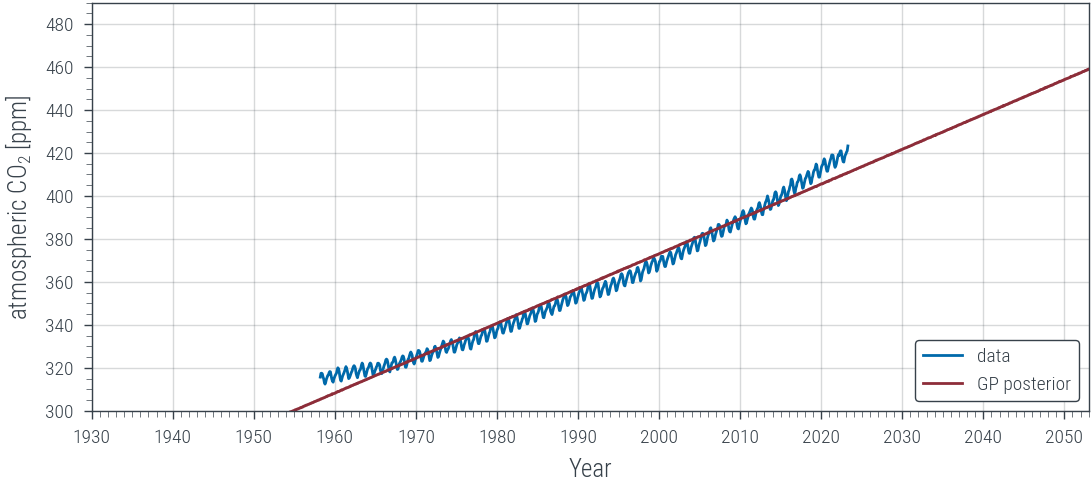

In [6]:
def linear_kernel(a, b, theta=1.0):
    return theta**2 * (jnp.sum(a * b, axis=-1) + 1.0)


def zero_mean(x):
    return jnp.zeros_like(x[:, 0])


prior = GaussianProcess(zero_mean, lambda a,
                        b: linear_kernel(a, b, theta=100.0))

posterior = prior.condition(Y, X, sigma)

fig, ax = plot_data()

posterior.plot_shaded(
    ax,
    x,
    color=rgb.tue_red,
    mean_kwargs={"label": "GP posterior"},
    std_kwargs={"alpha": 0.4, "cmap": cmap_rw},
    num_samples=2,
    rng_key=key,
)
ax.legend(loc="lower right", framealpha=1, facecolor="w");

We could also do "textbook" GP regression, e.g. using the Rational quadratic kernel

$$ k(a,b) = \theta^2 \left( 1 + \frac{(a-b)^2}{2\ell\alpha} \right)^{-\alpha}  $$ 

In [7]:
# or do generic GP regression:
def RQ_kernel(a, b, ell=1.0, alpha=1.0, theta=1.0):
    return theta**2 * (1 + jnp.sum((a - b) / ell, axis=-1) ** 2 / (2 * alpha)) ** (
        -alpha
    )


# we set the mean to a constant function at the data mean
mean_Y = jnp.mean(Y)


def constant_mean(x):
    return mean_Y * jnp.ones_like(x[:, 0])


# instantiate the Gaussian process prior
prior = GaussianProcess(
    constant_mean, functools.partial(RQ_kernel, ell=1.0, alpha=0.2, theta=3.0)
)

# condition the prior on the data

posterior = prior.condition(Y, X, sigma)

(782,) (782, 1)


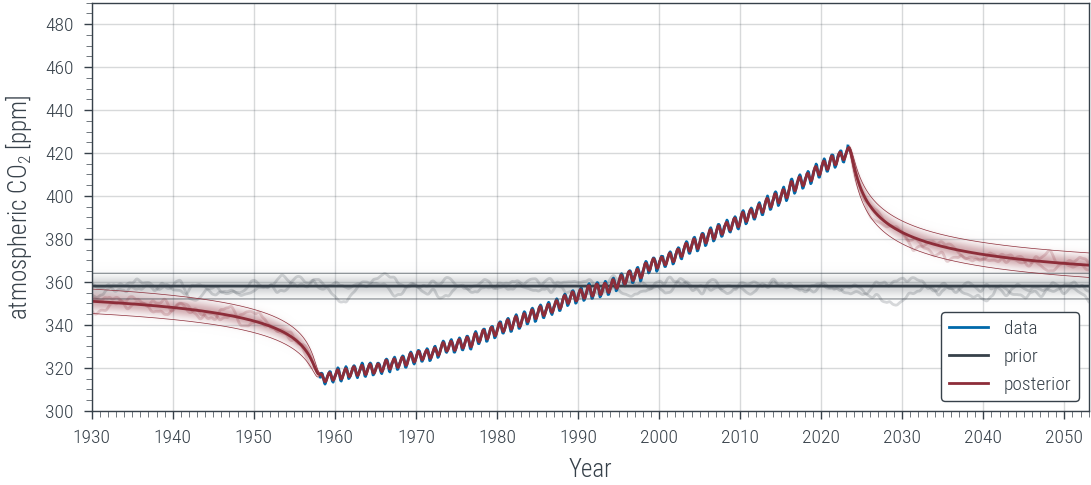

In [8]:
fig, ax = plot_data()

prior.plot_shaded(
    ax,
    x,
    color=rgb.tue_dark,
    mean_kwargs={"label": "prior"},
    std_kwargs={"alpha": 0.4, "cmap": cmap_dw},
    num_samples=2,
    rng_key=key,
)


posterior.plot_shaded(
    ax,
    x,
    color=rgb.tue_red,
    mean_kwargs={"label": "posterior"},
    std_kwargs={"alpha": 0.4, "cmap": cmap_rw},
    num_samples=2,
    rng_key=key,
)

ax.legend(loc="lower right", framealpha=1, facecolor="w");

Maybe it's better to model the long-term trend with a _very slowly_ varying function instead of a linear one. Because a linear model can not help but predict continuous growth in CO$_2$, which we hope will not actually happen.

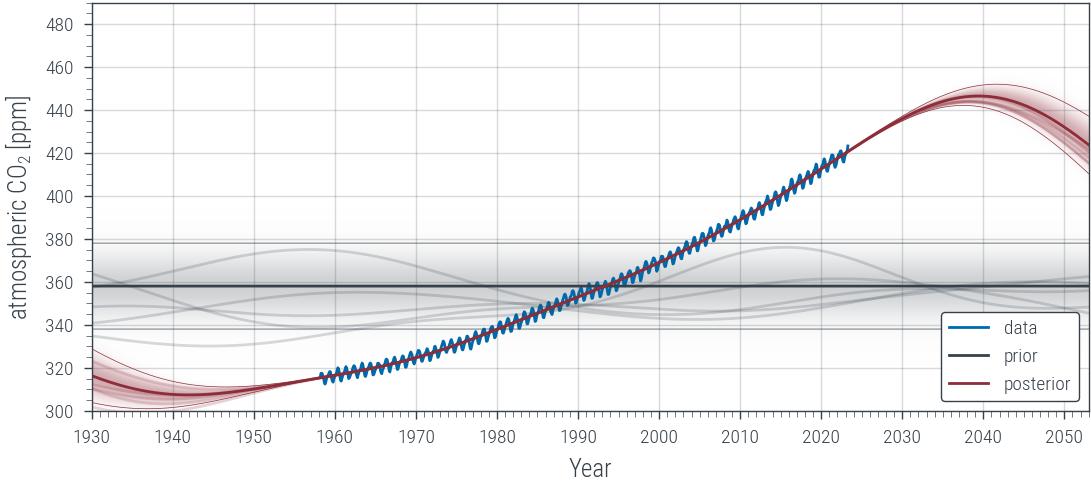

In [9]:
def long_term_trend_kernel(a, b, theta=1.0, ell=20.0):
    return theta**2 * jnp.exp(-jnp.sum((a - b) ** 2, axis=-1) / (2 * ell**2))


prior = GaussianProcess(
    constant_mean, functools.partial(
        long_term_trend_kernel, ell=20.0, theta=10.0)
)

# condition the prior on the data
posterior = prior.condition(Y, X, sigma)

fig, ax = plot_data()

prior.plot_shaded(
    ax,
    x,
    color=rgb.tue_dark,
    mean_kwargs={"label": "prior"},
    std_kwargs={"alpha": 0.4, "cmap": cmap_dw},
    num_samples=5,
    rng_key=key,
)


posterior.plot_shaded(
    ax,
    x,
    color=rgb.tue_red,
    mean_kwargs={"label": "posterior"},
    std_kwargs={"alpha": 0.4, "cmap": cmap_rw},
    num_samples=5,
    rng_key=key,
)

ax.legend(loc="lower right", framealpha=1, facecolor="w");

How about a *sum* of two GPs?

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

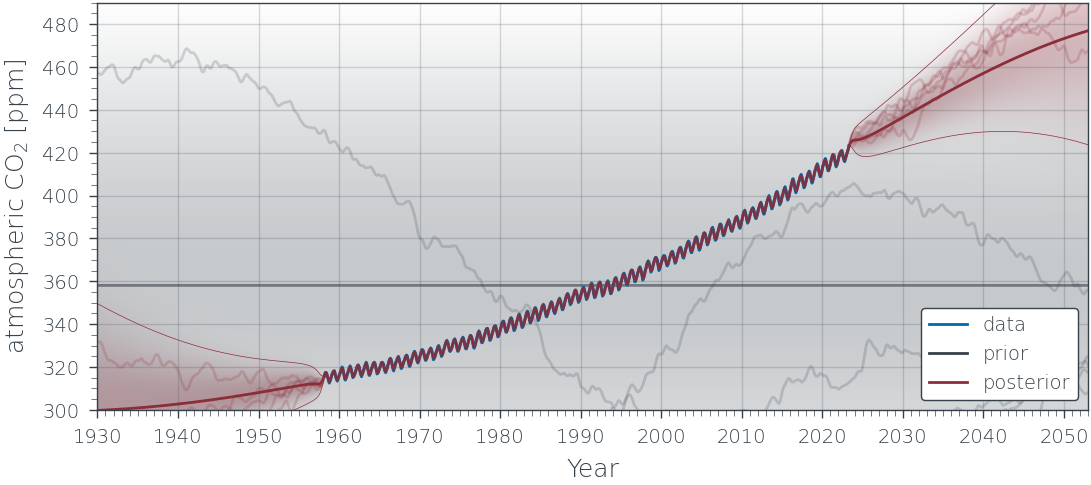

In [10]:
def sum_kernel(
    a, b, theta_long=1.0, theta_rq=1.0, ell_long_term=20.0, ell=1.0, alpha=1.0
):
    return long_term_trend_kernel(
        a, b, theta=theta_long, ell=ell_long_term
    ) + RQ_kernel(a, b, theta=theta_rq, ell=ell, alpha=alpha)


prior = GaussianProcess(
    constant_mean,
    functools.partial(
        sum_kernel,
        theta_long=100.0,
        theta_rq=5.0,
        ell_long_term=50.0,
        ell=1.0,
        alpha=0.2,
    ),
)

# condition the prior on the data
posterior = prior.condition(Y, X, sigma)

fig, ax = plot_data()

prior.plot_shaded(
    ax,
    x,
    color=rgb.tue_dark,
    mean_kwargs={"label": "prior", "zorder": -2},
    std_kwargs={"alpha": 0.4, "cmap": cmap_dw, "zorder": -2},
    num_samples=5,
    rng_key=key,
)

posterior.plot_shaded(
    ax,
    x,
    color=rgb.tue_red,
    yres=1000,
    mean_kwargs={"label": "posterior", "zorder": -2},
    std_kwargs={"alpha": 0.3, "cmap": cmap_rw, "zorder": -2},
    num_samples=5,
    rng_key=key,
)

ax.legend(loc="lower right", framealpha=1, facecolor="w");

Let's try to model the periodic component. A way to model periodic functions was introduced by [David JC MacKay](http://www.inference.org.uk/mackay/gpB.pdf) in 1998, using an embedding of the circle within the Euclidean plane: Consider the two dimensional transformation $ u(x) = (\cos(x),\sin( x))$ of the input $x$. If we use any stationary kernel $k(a,b)$ of the form `k(a,b) = k( ((a-b)**2).sum(axis=-1) )`, then we can apply it to $u(x)$ and use the trigonometric identity $(\cos(a) - \cos(b))^2 + (\sin(a) - \sin(b))^2 = 4\sin^2(\frac{a-b}{2})$ to get a kernel on the circle. For example, with the squared exponential kernel above, we get

$$ k(a,b) = \exp\left(-\frac{2 \sin^2\left(\frac{a-b}{2}\right)^2}{\ell^2}  \right) $$

We can change the period of the function to $T$ by applying the linear transformation $x \to \pi x / T $. In our case, we actually know that the period is $T=1.0$ years, no need to guess.

A minor complication is that we don't actually believe the function to be *perfectly* periodic. We can model a "decay in periodicity" over time by multiplying the kernel above with another stationary kernel of length-scale $\ell \gg T$

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

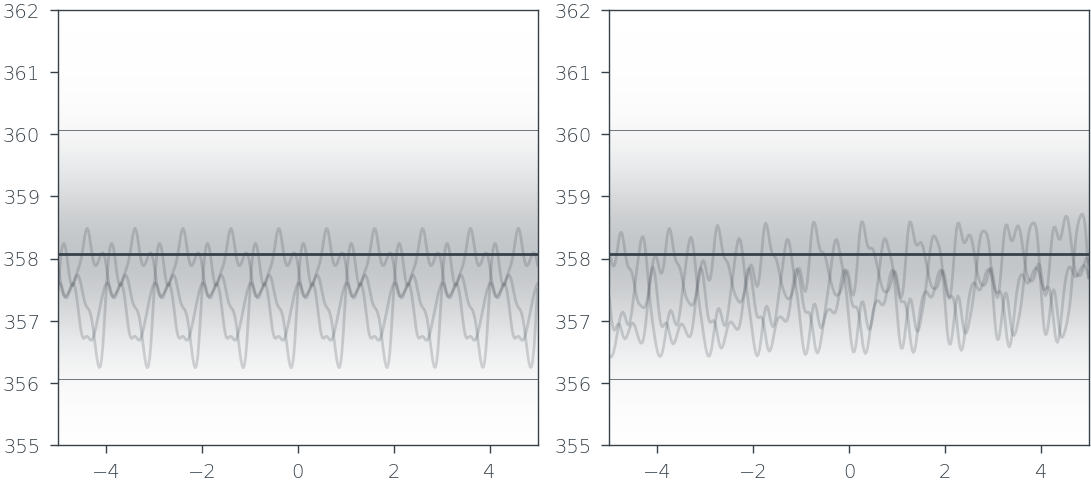

In [11]:
def periodic_kernel(x, y, period=1.0, ell=1.0, theta=1.0):
    return theta**2 * jnp.exp(
        -2 * jnp.sin(jnp.pi * jnp.sum(x - y, axis=-1) / period) ** 2 / ell
    )


prior = GaussianProcess(constant_mean, lambda a, b: periodic_kernel(a, b))

decayingprior = GaussianProcess(
    constant_mean,
    lambda a, b: periodic_kernel(
        a, b) * long_term_trend_kernel(a, b, ell=10, theta=1),
)

fig, axs = plt.subplots(1, 2)

for p, ax in zip([prior, decayingprior], axs):

    p.plot_shaded(
        ax,
        jnp.linspace(-5, 5, 400)[:, None],
        color=rgb.tue_dark,
        mean_kwargs={"label": "prior", "zorder": -2},
        yrange=(355, 362),
        std_kwargs={"alpha": 0.3, "cmap": cmap_dw, "zorder": -2},
        num_samples=3,
        rng_key=key,
    )

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

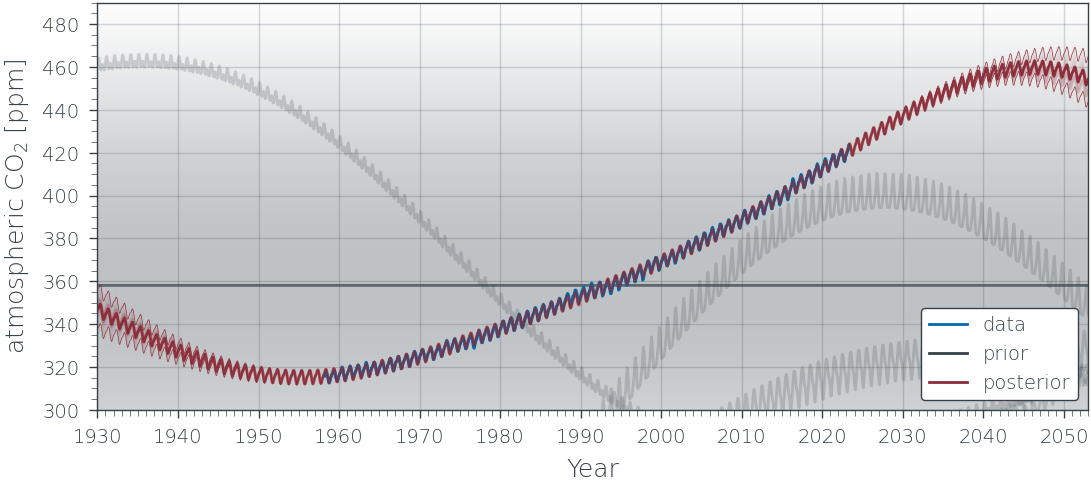

In [12]:
def sum_kernel(
    x, y, theta_long=1.0, theta_periodic=1.0, ell_long_term=20.0, ell_periodic=1.0
):
    return long_term_trend_kernel(
        x, y, theta=theta_long, ell=ell_long_term
    ) + periodic_kernel(x, y, theta=theta_periodic, ell=ell_periodic, period=1.0)


prior = GaussianProcess(
    constant_mean,
    functools.partial(
        sum_kernel,
        theta_long=100.0,
        theta_periodic=5.0,
        ell_long_term=50.0,
        ell_periodic=1.0,
    ),
)

# condition the prior on the data
posterior = prior.condition(Y, X, sigma)

fig, ax = plot_data()

prior.plot_shaded(
    ax,
    x,
    color=rgb.tue_dark,
    mean_kwargs={"label": "prior", "zorder": -2},
    std_kwargs={"alpha": 0.4, "cmap": cmap_dw, "zorder": -2},
    num_samples=5,
    rng_key=key,
)


posterior.plot_shaded(
    ax,
    x,
    yres=1000,
    color=rgb.tue_red,
    mean_kwargs={"label": "posterior", "zorder": -2},
    std_kwargs={"alpha": 0.2, "cmap": cmap_rw, "zorder": -2},
    num_samples=2,
    rng_key=key,
)

ax.legend(loc="lower right", framealpha=1, facecolor="w");

## Ok, time to set up a model

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

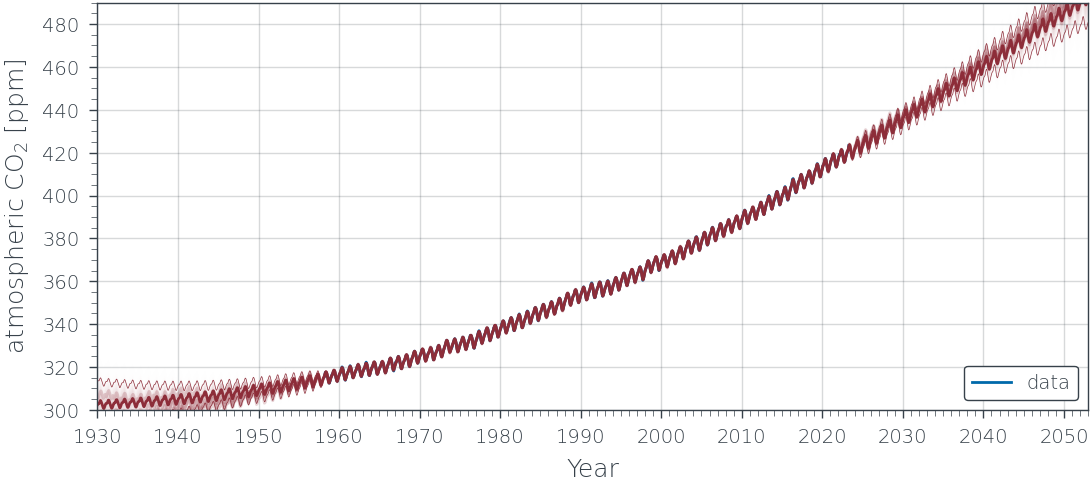

In [13]:
# The first component in the data is a long-term trend, which we model with the very smooth square exponential kernel
def long_term_trend_kernel(x, y, theta=100.0, ell=100.0):
    return theta**2 * jnp.exp(-jnp.sum((x - y) ** 2, axis=-1) / (2 * ell**2))


# Since know that the period is exactly one year, we do not need to expose this parameter.
def periodic_kernel(x, y, ell_period=1.0, ell_decay=50.0, theta=1.0):
    period = 1.0  # year
    return (
        theta**2
        * jnp.exp(
            -2
            * jnp.sin(jnp.pi * jnp.sum(x - y, axis=-1) / period) ** 2
            / ell_period**2
        )
        * jnp.exp(-jnp.sum((x - y) ** 2, axis=-1) / (2 * ell_decay**2))
    )


# the third component in the model is a medium-term trend, which we model with a rational quadratic kernel
def mid_term_trend(x, y, ell=1.0, alpha=1.0, theta=1.0):
    return theta**2 * (
        1 + jnp.sum((x - y) ** 2, axis=-1) / (2 * alpha * ell**2)
    ) ** (-alpha)


# finally, we account for local wheather phenomena in Hawaii with a "noise" term consisting of a squared
# exponential kernel with very small length scale, and a white noise term for measurement noise
def noise_kernel(x, y, ell=0.1, theta_weather=0.1, theta_measurement=0.1):
    return theta_weather**2 * jnp.exp(
        -jnp.sum((x - y) ** 2, axis=-1) / (2 * ell**2)
    ) + theta_measurement**2 * jnp.all(x == y, axis=-1)


def model_kernel(x, y, parameters):
    (
        theta_long,
        ell_long_term,
        theta_periodic,
        ell_decay_periodic,
        ell_periodic,
        theta_mid_term,
        ell_mid_term,
        shape_mid_term,
        theta_weather,
        ell_weather,
        theta_measurement,
    ) = parameters
    return (
        long_term_trend_kernel(x, y, theta=theta_long, ell=ell_long_term)
        + periodic_kernel(
            x,
            y,
            theta=theta_periodic,
            ell_period=ell_periodic,
            ell_decay=ell_decay_periodic,
        )
        + mid_term_trend(
            x, y, theta=theta_mid_term, ell=ell_mid_term, alpha=shape_mid_term
        )
        + noise_kernel(
            x,
            y,
            ell_weather,
            theta_weather=theta_weather,
            theta_measurement=theta_measurement,
        )
    )


# initial guesses for the parameters:
theta_long = 100.0  # ppm
ell_long_term = 100.0  # years
theta_periodic = 5.0  # ppm
ell_decay_periodic = 50.0  # years
ell_periodic = 1.0  # years
theta_mid_term = 1.0  # ppm
ell_mid_term = 1.0  # years
shape_mid_term = 1.0  # unitless
theta_weather = 0.1  # ppm
ell_weather = 0.1  # years
theta_measurement = 0.1  # ppm

init_params = jnp.asarray(
    [
        theta_long,
        ell_long_term,
        theta_periodic,
        ell_decay_periodic,
        ell_periodic,
        theta_mid_term,
        ell_mid_term,
        shape_mid_term,
        theta_weather,
        ell_weather,
        theta_measurement,
    ]
)

# define the model
gp = GaussianProcess(
    constant_mean,
    functools.partial(model_kernel, parameters=init_params),
)

# condition the prior on the data
gp_posterior = gp.condition(Y, X, sigma)

fig, ax = plot_data()
gp_posterior.plot_shaded(
    ax,
    x,
    yres=1000,
    color=rgb.tue_red,
    mean_kwargs={"label": "GP posterior mean"},
    std_kwargs={"alpha": 0.2, "cmap": cmap_rw},
    num_samples=5,
    rng_key=key,
)

This model is not bad. Let's see if we could pick out the data if we drew from the prior:

(196.0475831885394, 529.0088025422906)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

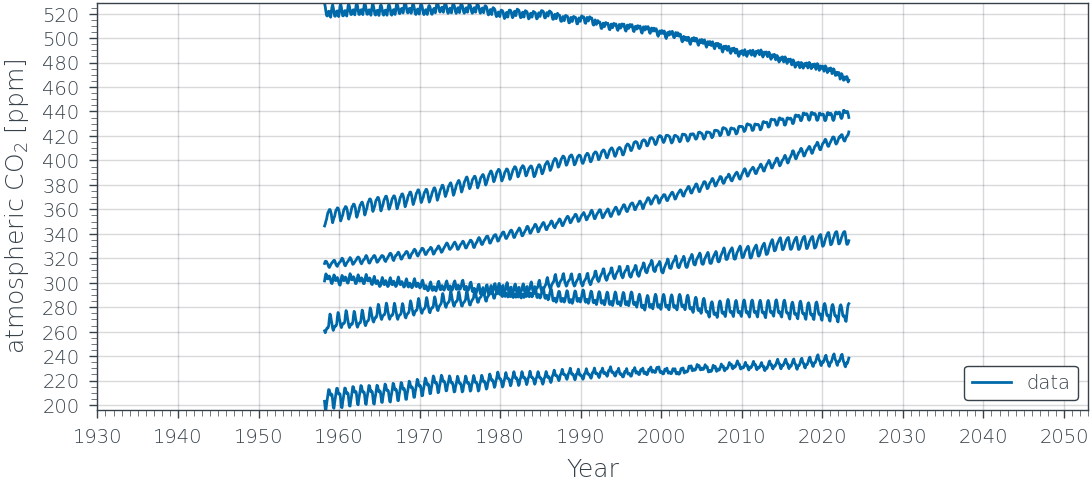

In [14]:
samples = gp(X).sample(key=key, num_samples=5)
fig, ax = plot_data()
ax.plot(X, samples.T, color=rgb.tue_blue, alpha=1.0)
ax.set_ylim([jnp.min(samples[:]), jnp.max(samples[:])])

This looks decent, but let's see if we can do this even better, by

## Hyperparameter optimiziation

In [15]:
from jax import grad, hessian
from scipy import optimize


def NegEvidence(params):
    gp = GaussianProcess(
        constant_mean,
        functools.partial(model_kernel, parameters=params),
    )
    return -gp(X).log_pdf(Y)


grad_neg_ev = grad(NegEvidence)
# hess_neg_ev = hessian(NegEvidence)

params = init_params

# init_negevidence = NegEvidence(params)
# grad_init = grad_neg_ev(params)
# print(init_negevidence, grad_init)

results = optimize.minimize(
    NegEvidence,
    params,
    method="CG",
    jac=grad(NegEvidence),
    options={"gtol": 1e-6, "disp": True, "maxiter": 100},
)

         Current function value: 217.133052
         Iterations: 45
         Function evaluations: 120
         Gradient evaluations: 111


In [16]:
# # an alternative choice of parameters was found in Rasmussen & Williams (2006):
# theta_long = 66.0  # ppm
# ell_long_term = 67.0  # years
# theta_periodic = 2.4  # ppm
# ell_decay_periodic = 90.0  # years
# ell_periodic = 1.3  # years
# theta_mid_term = 0.66  # ppm
# ell_mid_term = 1.2  # years
# shape_mid_term = 0.78  # unitless
# theta_weather = 0.18  # ppm
# ell_weather = 0.13  # years
# theta_measurement = 0.19  # ppm

RW_params = [66.0, 67.0, 2.4, 90.0, 1.3, 0.66, 1.2, 0.78, 0.18, 0.13, 0.19]
units = [
    "ppm",
    "years",
    "ppm",
    "years",
    "years",
    "ppm",
    "years",
    "",
    "ppm",
    "years",
    "ppm",
]

names = [
    "theta_long",
    "ell_long_term",
    "theta_periodic",
    "ell_decay_periodic",
    " ell_periodic",
    "theta_mid_term",
    "ell_mid_term",
    "shape_mid_term",
    "theta_weather",
    "ell_weather",
    "theta_measurement",
]

for p, name, r, i, u in zip(results.x, names, RW_params, init_params, units):
    print(
        name.rjust(25)
        + f"{i:9.2f}"
        + "  ->  "
        + f"{p:6.2f}"
        + 5 * " "
        + "Ref: "
        + f"{r:6.2f}"
        + " "
        + u
    )

               theta_long   100.00  ->  100.01     Ref:  66.00 ppm
            ell_long_term   100.00  ->   99.99     Ref:  67.00 years
           theta_periodic     5.00  ->    4.60     Ref:   2.40 ppm
       ell_decay_periodic    50.00  ->   50.07     Ref:  90.00 years
             ell_periodic     1.00  ->    1.79     Ref:   1.30 years
           theta_mid_term     1.00  ->    0.80     Ref:   0.66 ppm
             ell_mid_term     1.00  ->    1.37     Ref:   1.20 years
           shape_mid_term     1.00  ->    0.34     Ref:   0.78 
            theta_weather     0.10  ->    0.20     Ref:   0.18 ppm
              ell_weather     0.10  ->    0.13     Ref:   0.13 years
        theta_measurement     0.10  ->    0.20     Ref:   0.19 ppm


Text(0.5, 1.0, 'prediction')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

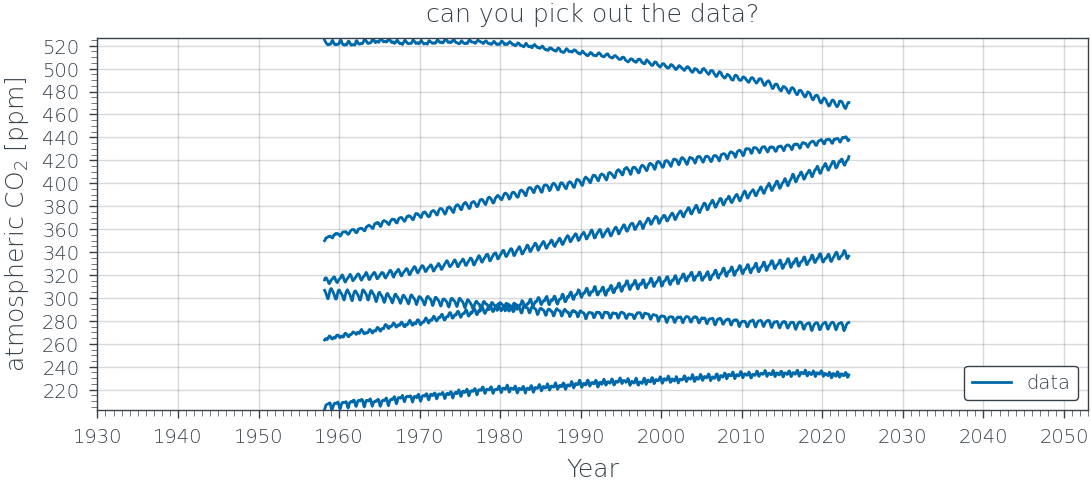

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

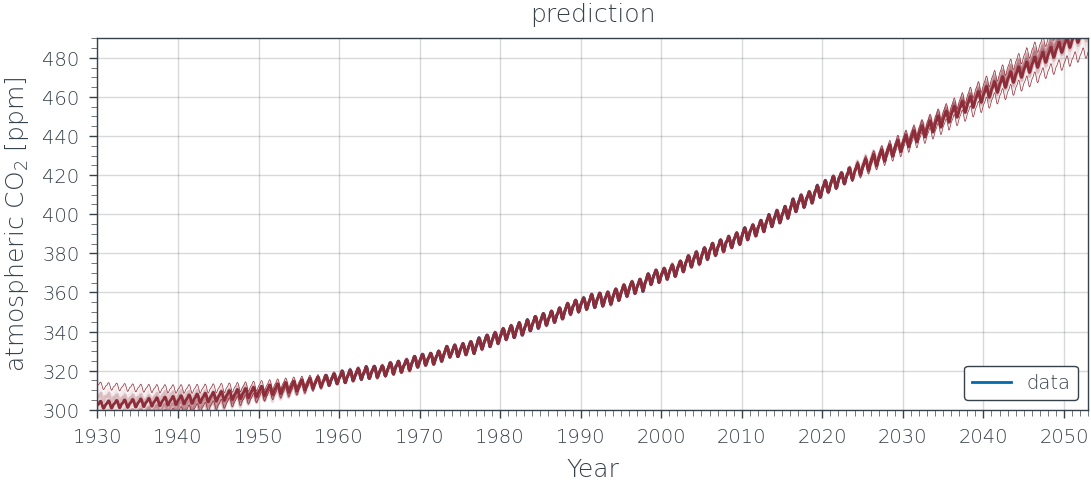

In [17]:
opt_params = jnp.asarray(results.x)

gp = GaussianProcess(
    constant_mean,
    functools.partial(model_kernel, parameters=opt_params),
)
gp_posterior = gp.condition(Y, X, sigma)


samples = gp(X).sample(key=key, num_samples=5)
fig, ax = plot_data()
ax.plot(X, samples.T, color=rgb.tue_blue, alpha=1.0)
ax.set_ylim([jnp.min(samples[:]), jnp.max(samples[:])])
ax.set_title("can you pick out the data?")


fig, ax = plot_data()
gp_posterior.plot_shaded(
    ax,
    x,
    yres=1000,
    color=rgb.tue_red,
    mean_kwargs={"label": "GP posterior mean"},
    std_kwargs={"alpha": 0.2, "cmap": cmap_rw},
    num_samples=5,
    rng_key=key,
)
ax.set_title("prediction")

## Source Separation

One neat aspect of this GP model is that we can also consider the marginal distributions of individual components in the sum model.

In [18]:
# first, the long-term component:
k_long = functools.partial(
    long_term_trend_kernel,
    theta=opt_params[0],
    ell=opt_params[1],
)

long_term_GP = gp_posterior.project(k_long)

# the medium-term component:
k_mid = functools.partial(
    mid_term_trend, theta=opt_params[5], ell=opt_params[6], alpha=opt_params[7]
)

mid_term_GP = gp_posterior.project(k_mid, lambda x: jnp.zeros_like(x[..., 0]))

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

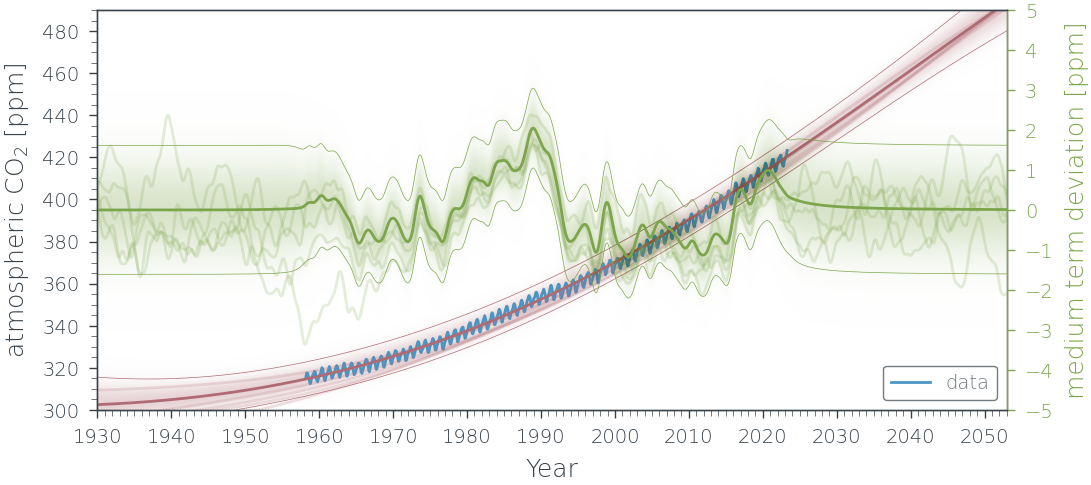

In [19]:
fig, ax = plot_data()
long_term_GP.plot_shaded(
    ax,
    x,
    color=rgb.tue_red,
    mean_kwargs={"label": "long term prediction posterior mean"},
    std_kwargs={"alpha": 0.3, "cmap": cmap_rw},
    num_samples=5,
    rng_key=key,
)

ax2 = ax.twinx()
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
# ax2.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax2.set_ylim([-5, 5])
ax2.yaxis.label.set_color(rgb.tue_green)
ax2.spines["right"].set_color(rgb.tue_green)
ax2.tick_params(axis="y", colors=rgb.tue_green)
ax2.set_ylabel("medium term deviation [ppm]")
ax.grid(False)

mid_term_GP.plot_shaded(
    ax2,
    x,
    color=rgb.tue_green,
    mean_kwargs={"label": "mid term prediction posterior mean"},
    std_kwargs={"alpha": 0.3, "cmap": cmap_gw},
    num_samples=5,
    rng_key=key,
)

In [20]:
import numpy as np

# and the periodic component:
k_periodic = functools.partial(
    periodic_kernel,
    ell_period=opt_params[4],
    ell_decay=opt_params[3],
    theta=opt_params[2],
)

periodic_GP = gp_posterior.project(
    k_periodic, lambda x: jnp.zeros_like(x[..., 0]))

res = 20
x_period = np.zeros((80 * 12 * res, 1))
for y in range(80):
    for m in range(12 * res):
        x_period[y * 12 * res + m] = 1960 + y + m / (12 * res)

m_period = (periodic_GP(x_period).mu)[:, None]
s_period = (periodic_GP(x_period).std)[:, None]
s_period = s_period - np.min(s_period)
s_period = s_period / np.max(s_period)

fig, ax = plt.subplots()
im = ax.imshow(
    m_period.reshape(80, 12 * res),
    aspect="auto",
    alpha=1 - s_period.reshape(80, 12 * res),
    cmap=cmap_bwr,
    origin="lower",
    extent=[0, 12, 1960, 2040],
)
cbar = fig.colorbar(im)
cbar.set_label("periodic component [ppm]")
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xlabel("Month")
ax.set_ylabel("Year")
ax.grid(axis="both")

: 

: 